# Aplicación de Transfer Learning

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
!pip install torchinfo

## Conjunto de datos a usar: 
https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

In [34]:
import torch
import torchvision
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader,TensorDataset,Dataset

import dl_rice #Este código lo crea el GUI generador de Dataset
from helper_evaluation import compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy

In [35]:
BATCH_SIZE = 32

### Crear Dataset con el código creado

In [36]:
Dataset = dl_rice.ImageDataset()

In [37]:
print(len(Dataset))
l_ds = len(Dataset)

#Dividir el conjunto de datos en entrenamiento/validación/test
l_tr = int(round(l_ds*0.8))
l_valtest = int(l_ds - l_tr)

l_val = int(l_valtest*0.5)
l_test = int(l_valtest - l_val)


75000


In [38]:
train_set, val_set = torch.utils.data.random_split(Dataset,[l_tr,l_valtest])
val_set, test_set = torch.utils.data.random_split(val_set,
                                                  [l_val, l_test])


In [39]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

60000
7500
7500


In [40]:
train_iterator = DataLoader(train_set,
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = 2)

val_iterator = DataLoader(val_set,
                          batch_size = BATCH_SIZE)

test_iterator = DataLoader(test_set,
                           batch_size = BATCH_SIZE)

In [41]:
it_dl = iter(train_iterator)

In [42]:
image, label = next(it_dl)

In [43]:
print(image.shape)
print(label)

torch.Size([32, 1, 32, 32])
tensor([2, 2, 1, 0, 1, 0, 0, 2, 3, 2, 0, 3, 1, 1, 3, 4, 3, 0, 4, 0, 4, 1, 2, 1,
        2, 3, 3, 0, 4, 3, 2, 4])


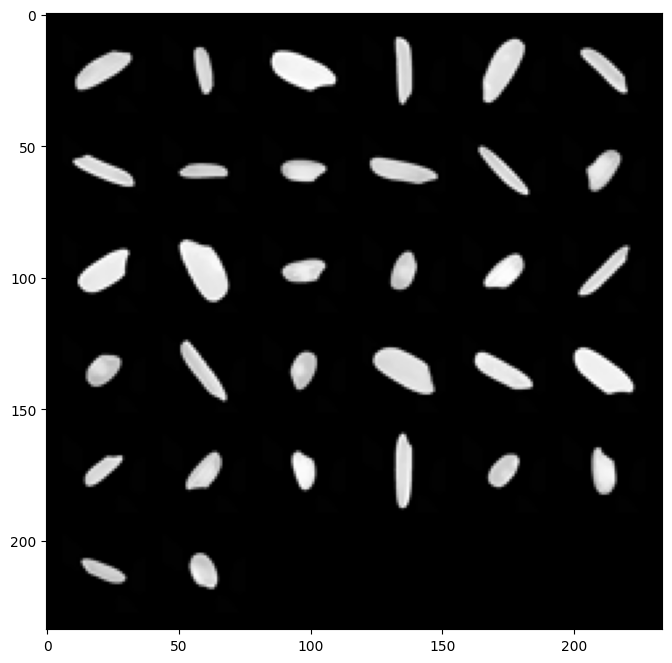

In [44]:
grid = torchvision.utils.make_grid(image, 6, 6)
plt.figure(figsize=(8,8))
plt.imshow(F.to_pil_image(grid))

In [45]:
for images, labels in train_iterator:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 32, 32])
Image label dimensions: torch.Size([32])


## Transfer Learning: Usar modelos preentrenados

In [46]:
!pip install timm

In [47]:
import timm

In [48]:
# all_models = timm.list_models('mob*')
all_models = timm.list_models('eff*')
len(all_models)
all_models

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientformerv2_l',
 'efficientformerv2_s0',
 'efficientformerv2_s1',
 'efficientformerv2_s2',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'e

In [49]:
model = timm.create_model('mobilenetv3_small_050', 
                          num_classes = 5, 
                          pretrained = True,
                          in_chans = 1)

In [50]:
model

MobileNetV3(
  (conv_stem): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          8

In [51]:
summary(model, (32, 1, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [32, 5]                   --
├─Conv2d: 1-1                                 [32, 16, 16, 16]          144
├─BatchNormAct2d: 1-2                         [32, 16, 16, 16]          32
│    └─Identity: 2-1                          [32, 16, 16, 16]          --
│    └─Hardswish: 2-2                         [32, 16, 16, 16]          --
├─Sequential: 1-3                             [32, 288, 1, 1]           --
│    └─Sequential: 2-3                        [32, 8, 8, 8]             --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 8, 8, 8]             600
│    └─Sequential: 2-4                        [32, 16, 4, 4]            --
│    │    └─InvertedResidual: 3-2             [32, 16, 4, 4]            1,512
│    │    └─InvertedResidual: 3-3             [32, 16, 4, 4]            2,552
│    └─Sequential: 2-5                        [32, 24, 2, 2]            --
│    │    └─

### Uso del modelo

In [52]:
x = torch.randn(2, 1, 32, 32)
model(x).shape

torch.Size([2, 5])

In [53]:
model(x)

tensor([[-18.3472,   0.1228,  -8.5065, -10.5111,   1.7749],
        [-11.5807,  12.7011,   9.3169,   1.3452,  -4.4953]],
       grad_fn=<AddmmBackward0>)

In [54]:
torch.nn.functional.softmax(model(x), dim=-1)

tensor([[1.5307e-09, 1.6081e-01, 2.8752e-05, 3.8734e-06, 8.3916e-01],
        [2.7545e-11, 9.6720e-01, 3.2791e-02, 1.1316e-05, 3.2899e-08]],
       grad_fn=<SoftmaxBackward0>)

In [55]:
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Resultado de modelo preentrenado

In [56]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(20.5200)

## Congelar parámetros menos FC

In [57]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight True
bn1.weight True
bn1.bias True
blocks.0.0.conv_dw.weight True
blocks.0.0.bn1.weight True
blocks.0.0.bn1.bias True
blocks.0.0.se.conv_reduce.weight True
blocks.0.0.se.conv_reduce.bias True
blocks.0.0.se.conv_expand.weight True
blocks.0.0.se.conv_expand.bias True
blocks.0.0.conv_pw.weight True
blocks.0.0.bn2.weight True
blocks.0.0.bn2.bias True
blocks.1.0.conv_pw.weight True
blocks.1.0.bn1.weight True
blocks.1.0.bn1.bias True
blocks.1.0.conv_dw.weight True
blocks.1.0.bn2.weight True
blocks.1.0.bn2.bias True
blocks.1.0.conv_pwl.weight True
blocks.1.0.bn3.weight True
blocks.1.0.bn3.bias True
blocks.1.1.conv_pw.weight True
blocks.1.1.bn1.weight True
blocks.1.1.bn1.bias True
blocks.1.1.conv_dw.weight True
blocks.1.1.bn2.weight True
blocks.1.1.bn2.bias True
blocks.1.1.conv_pwl.weight True
blocks.1.1.bn3.weight True
blocks.1.1.bn3.bias True
blocks.2.0.conv_pw.weight True
blocks.2.0.bn1.weight True
blocks.2.0.bn1.bias True
blocks.2.0.conv_dw.weight True
blocks.2.0.bn2.weigh

In [58]:
for param in model.parameters():
    param.requires_grad = False

In [59]:
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

In [60]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight False
bn1.weight False
bn1.bias False
blocks.0.0.conv_dw.weight False
blocks.0.0.bn1.weight False
blocks.0.0.bn1.bias False
blocks.0.0.se.conv_reduce.weight False
blocks.0.0.se.conv_reduce.bias False
blocks.0.0.se.conv_expand.weight False
blocks.0.0.se.conv_expand.bias False
blocks.0.0.conv_pw.weight False
blocks.0.0.bn2.weight False
blocks.0.0.bn2.bias False
blocks.1.0.conv_pw.weight False
blocks.1.0.bn1.weight False
blocks.1.0.bn1.bias False
blocks.1.0.conv_dw.weight False
blocks.1.0.bn2.weight False
blocks.1.0.bn2.bias False
blocks.1.0.conv_pwl.weight False
blocks.1.0.bn3.weight False
blocks.1.0.bn3.bias False
blocks.1.1.conv_pw.weight False
blocks.1.1.bn1.weight False
blocks.1.1.bn1.bias False
blocks.1.1.conv_dw.weight False
blocks.1.1.bn2.weight False
blocks.1.1.bn2.bias False
blocks.1.1.conv_pwl.weight False
blocks.1.1.bn3.weight False
blocks.1.1.bn3.bias False
blocks.2.0.conv_pw.weight False
blocks.2.0.bn1.weight False
blocks.2.0.bn1.bias False
blocks.2.0.conv_d

In [61]:
summary(model, (32,1, 32, 32))


Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [32, 5]                   --
├─Conv2d: 1-1                                 [32, 16, 16, 16]          (144)
├─BatchNormAct2d: 1-2                         [32, 16, 16, 16]          32
│    └─Identity: 2-1                          [32, 16, 16, 16]          --
│    └─Hardswish: 2-2                         [32, 16, 16, 16]          --
├─Sequential: 1-3                             [32, 288, 1, 1]           --
│    └─Sequential: 2-3                        [32, 8, 8, 8]             --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 8, 8, 8]             (600)
│    └─Sequential: 2-4                        [32, 16, 4, 4]            --
│    │    └─InvertedResidual: 3-2             [32, 16, 4, 4]            (1,512)
│    │    └─InvertedResidual: 3-3             [32, 16, 4, 4]            (2,552)
│    └─Sequential: 2-5                        [32, 24, 2, 2]            --
│   

In [62]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_iterator,
    valid_loader=val_iterator,
    test_loader=test_iterator,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=300)

Epoch: 001/010 | Batch 0000/1875 | Loss: 17.9229
Epoch: 001/010 | Batch 0300/1875 | Loss: 3.9829
Epoch: 001/010 | Batch 0600/1875 | Loss: 3.1012
Epoch: 001/010 | Batch 0900/1875 | Loss: 4.5587
Epoch: 001/010 | Batch 1200/1875 | Loss: 3.1661
Epoch: 001/010 | Batch 1500/1875 | Loss: 4.0182
Epoch: 001/010 | Batch 1800/1875 | Loss: 8.0993
Epoch: 001/010 | Train: 81.81% | Validation: 81.72%
Time elapsed: 3.71 min
Epoch: 002/010 | Batch 0000/1875 | Loss: 2.8420
Epoch: 002/010 | Batch 0300/1875 | Loss: 2.9035
Epoch: 002/010 | Batch 0600/1875 | Loss: 1.8933
Epoch: 002/010 | Batch 0900/1875 | Loss: 2.1623
Epoch: 002/010 | Batch 1200/1875 | Loss: 3.3057
Epoch: 002/010 | Batch 1500/1875 | Loss: 3.1334
Epoch: 002/010 | Batch 1800/1875 | Loss: 3.6865
Epoch: 002/010 | Train: 80.54% | Validation: 80.11%
Time elapsed: 7.43 min
Epoch: 003/010 | Batch 0000/1875 | Loss: 3.6203
Epoch: 003/010 | Batch 0300/1875 | Loss: 2.6798
Epoch: 003/010 | Batch 0600/1875 | Loss: 4.3117
Epoch: 003/010 | Batch 0900/1875 

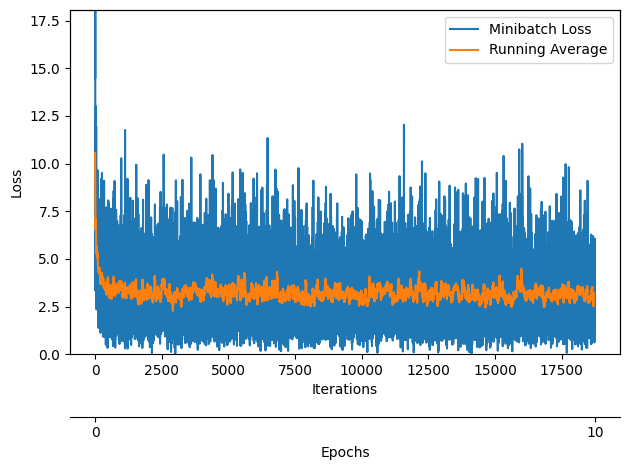

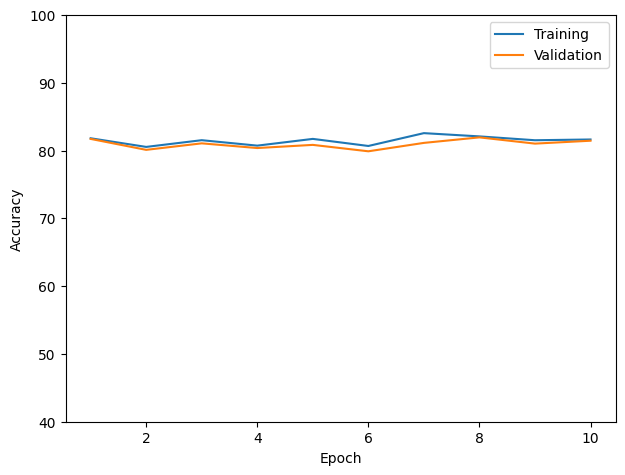

In [63]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_iterator),
                   results_dir=None,
                   averaging_iterations=40)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([40, 100])
plt.show()

In [64]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(81.7467)

## Entrenar modelo completo

In [68]:
model = timm.create_model('mobilenetv3_small_050', 
                          num_classes = 5, 
                          pretrained = True,
                          in_chans = 1)

In [69]:
for param in model.parameters():
    print(param.requires_grad,end=' ')

True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True 

In [70]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_iterator,
    valid_loader=val_iterator,
    test_loader=test_iterator,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=500)

Epoch: 001/010 | Batch 0000/1875 | Loss: 19.7720
Epoch: 001/010 | Batch 0500/1875 | Loss: 0.2680
Epoch: 001/010 | Batch 1000/1875 | Loss: 0.0313
Epoch: 001/010 | Batch 1500/1875 | Loss: 0.3233
Epoch: 001/010 | Train: 93.43% | Validation: 93.00%
Time elapsed: 2.92 min
Epoch: 002/010 | Batch 0000/1875 | Loss: 0.3186
Epoch: 002/010 | Batch 0500/1875 | Loss: 0.0980
Epoch: 002/010 | Batch 1000/1875 | Loss: 0.2123
Epoch: 002/010 | Batch 1500/1875 | Loss: 0.1896
Epoch: 002/010 | Train: 96.37% | Validation: 96.13%
Time elapsed: 5.83 min
Epoch: 003/010 | Batch 0000/1875 | Loss: 0.1498
Epoch: 003/010 | Batch 0500/1875 | Loss: 0.1849
Epoch: 003/010 | Batch 1000/1875 | Loss: 0.0745
Epoch: 003/010 | Batch 1500/1875 | Loss: 0.0721
Epoch: 003/010 | Train: 96.77% | Validation: 96.16%
Time elapsed: 8.78 min
Epoch: 004/010 | Batch 0000/1875 | Loss: 0.1914
Epoch: 004/010 | Batch 0500/1875 | Loss: 0.0388
Epoch: 004/010 | Batch 1000/1875 | Loss: 0.0816
Epoch: 004/010 | Batch 1500/1875 | Loss: 0.0329
Epoch:

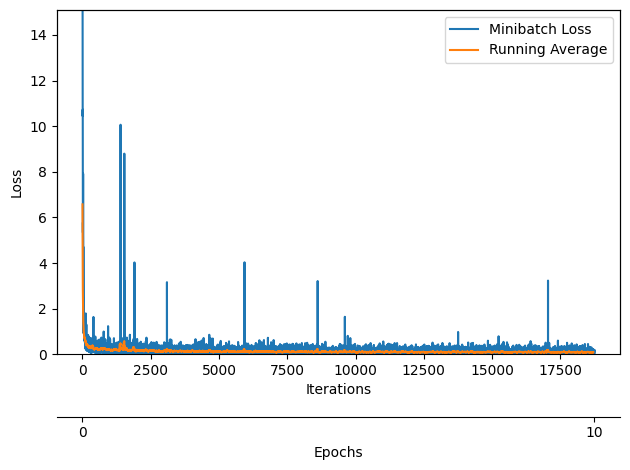

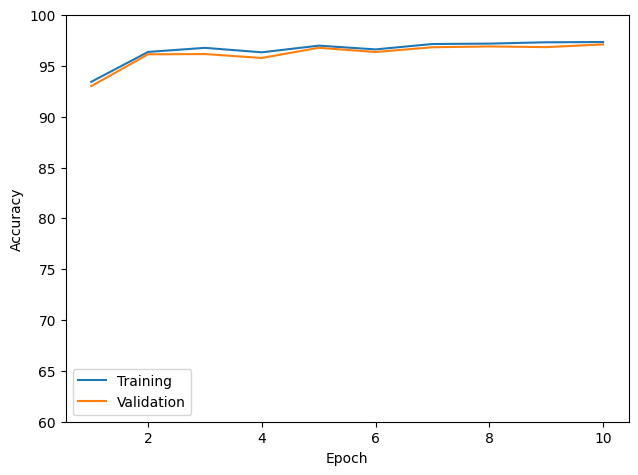

In [71]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_iterator),
                   results_dir=None,
                   averaging_iterations=40)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [72]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(97.1467)